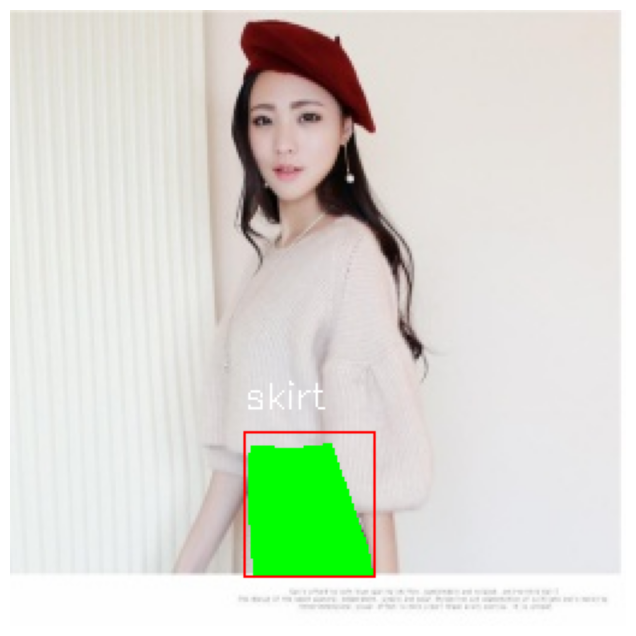

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

# CSV 경로 및 이미지 디렉토리 경로
csv_path = '/Volumes/T7 Shield/deepfashion2/DeepFashion2 Resized/input/validation.csv'
image_dir = '/Volumes/T7 Shield/deepfashion2/DeepFashion2 Resized/resized/validation'

# CSV 파일 읽기
data = pd.read_csv(csv_path)

def normalize_landmarks(landmarks, orig_width, orig_height, target_width, target_height):
    """
    Landmarks만 정규화하고 스케일링합니다.
    
    Args:
    - landmarks (list): 원본 이미지 기준 [x1, y1, v1, x2, y2, v2, ...] 형식의 좌표
    - orig_width (int): 원본 이미지의 너비
    - orig_height (int): 원본 이미지의 높이
    - target_width (int): 대상 이미지의 너비
    - target_height (int): 대상 이미지의 높이
    
    Returns:
    - scaled_landmarks (list): 정규화 및 스케일링된 좌표 리스트
    """
    scaled_landmarks = []
    for i in range(0, len(landmarks), 3):
        x, y, visibility = landmarks[i], landmarks[i + 1], landmarks[i + 2]
        # 정규화 및 스케일링
        x = (x / orig_width) * target_width
        y = (y / orig_height) * target_height
        scaled_landmarks.extend([x, y, visibility])
    return scaled_landmarks

def draw_annotations(image_path, annotations, target_size=(256, 256)):
    """
    주어진 이미지 경로에서 이미지를 읽고, 주석 정보를 이미지에 그립니다.
    
    Args:
    - image_path (str): 이미지 파일 경로
    - annotations (dict): 주석 정보 (bounding box, segmentation, landmarks 등)
    - target_size (tuple): 현재 이미지 크기 (width, height)
    """
    # 이미지 읽기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽으므로 RGB로 변환
    
    # Bounding Box 그리기
    bbox = eval(annotations['b_box'])  # 리스트 형태일 경우 그대로 사용
    x_min, y_min, x_max, y_max = [int(coord) for coord in bbox]
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)  # 두께 1로 설정
    
    # Segmentation 그리기 (원본 좌표 그대로 사용)
    segmentation = eval(annotations['segmentation'])
    if isinstance(segmentation[0], list):  # segmentation이 중첩된 리스트인지 확인
        segmentation = [point for sublist in segmentation for point in sublist]
    segmentation_points = [
        (int(segmentation[i]), int(segmentation[i + 1])) for i in range(0, len(segmentation), 2)
    ]
    cv2.fillPoly(image, [np.array(segmentation_points, np.int32)], color=(0, 255, 0, 50))  # 연한 초록색으로 채움
    
    # Landmarks 정규화 및 스케일링
    orig_height, orig_width = int(annotations['img_height']), int(annotations['img_width'])  # 원본 이미지 크기
    landmarks = eval(annotations['landmarks'])
    normalized_landmarks = normalize_landmarks(landmarks, orig_width, orig_height, target_size[0], target_size[1])
    
    # Landmarks 그리기
    for i in range(0, len(normalized_landmarks), 3):
        x, y, visibility = normalized_landmarks[i], normalized_landmarks[i + 1], normalized_landmarks[i + 2]
        if visibility > 0:  # visibility가 0 이상인 점만 표시
            x, y = int(x), int(y)
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)  # 빨간색 점
            cv2.putText(image, f"({x}, {y})", (x + 5, y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    # Category Name 추가
    category_name = annotations['category_name']
    cv2.putText(image, category_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return image

# 랜덤하게 하나의 데이터 선택
random_row = data.sample(n=1).iloc[0]  # 랜덤하게 한 행 선택

# 이미지 경로 생성
image_name = os.path.basename(random_row['path'])  # 파일 이름만 가져옴
image_path = os.path.join(image_dir, image_name)  # 전체 경로 생성

if not os.path.exists(image_path):
    print(f"이미지 {image_path} 가 존재하지 않습니다.")
else:
    # 주석 정보 가져오기
    annotations = {
        'b_box': random_row['b_box'],
        'segmentation': random_row['segmentation'],
        'landmarks': random_row['landmarks'],
        'category_name': random_row['category_name'],
        'img_height': random_row['img_height'],
        'img_width': random_row['img_width']
    }
    
    # 주석 정보가 포함된 이미지 생성
    annotated_image = draw_annotations(image_path, annotations, target_size=(256, 256))
    
    # 이미지 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()
